## 패키지 install

In [1]:
!pip install mxnet
!pip install gluonnlp pandas tqdm
!pip install sentencepiece
!pip install transformers==3.0.2
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 13.6 MB/s eta 0:00:00
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 344.5/344.5 KB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp38-cp38-linux_x86_64.whl size=689010 sha256=536d2d74266b68ac1f793477150f9f8d2f57df4b81498c75d1a9b3956b8d6d1e
  Stored in directory: /root/.cache/pip/wheels/b6/93/9d/2237550c409eb3ed725d6302b7897ddd9a037b40cef66dcd9c
Successfully built gluonnlp
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://****@github.com/SKTBrain/KoBERT.git (to revision master) to /tmp/pip-req-build-7aswe70x
  Running command git clone --filter=blob:none --quiet 'https://****@github.com/SKTBrain/KoBERT.git' /tmp/pip-req-build-7aswe70x
  Resolved https://****@github.com/SKTBrain/KoBERT.git to commit 47a69af87928fc24e20f571fe10c3cc9dd9af9a3
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 KB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 MB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 76.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 36.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 881.3/881.9 MB 89.1 MB/s eta 0:00:01tcmalloc: large alloc 1102397440 bytes == 0x3bb1a000 @  0x7f803172d680 0x7f803174dda2 0x5f714c 0x64d800 0x527022 0x50486

## import package

In [3]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, tqdm_notebook

In [4]:
#kobert
from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model

#transformers
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

In [5]:
#GPU 사용
device = torch.device("cuda:0")
# device = torch.device("cpu")

## Dataset

In [6]:
#BERT 모델, Vocabulary 불러오기
bertmodel, vocab = get_pytorch_kobert_model()

/content/.cache/kobert_v1.zip[██████████████████████████████████████████████████]
/content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece[██████████████████████████████████████████████████]


In [7]:
import pandas as pd

data = pd.read_csv('한국어_단발성_대화_정리3000.csv')

In [8]:
data.loc[(data['Emotion'] == "행복"), 'Emotion'] = 0  #행복 => 0
data.loc[(data['Emotion'] == "중립"), 'Emotion'] = 1  #중립 => 1
data.loc[(data['Emotion'] == "불안"), 'Emotion'] = 2  #불안 => 2
data.loc[(data['Emotion'] == "슬픔"), 'Emotion'] = 3  #슬픔 => 3
data.loc[(data['Emotion'] == "분노"), 'Emotion'] = 4  #분노 => 4

In [9]:
# Setting parameters
max_len = 64
batch_size = 32
warmup_ratio = 0.1
num_epochs = 10
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

In [10]:
data_list = []
for ques, label in zip(data['Sentence'], data['Emotion']):
    data = []   
    data.append(ques)
    data.append(str(label))

    data_list.append(data)

In [11]:
dataset_size = len(data_list)
train_size = int(dataset_size * 0.7)
validation_size = int(dataset_size * 0.15)
test_size = dataset_size - train_size - validation_size

print(dataset_size, train_size, validation_size, test_size)

14438 10106 2165 2167


In [12]:
from torch.utils.data import Dataset, DataLoader, random_split

dataset_train, dataset_validation, dataset_test = random_split(data_list, [train_size, validation_size, test_size])

print(f"Training Data Size : {len(dataset_train)}")
print(f"Validation Data Size : {len(dataset_validation)}")
print(f"Testing Data Size : {len(dataset_test)}")

Training Data Size : 10106
Validation Data Size : 2165
Testing Data Size : 2167


In [13]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

In [14]:
# 토큰화
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

# BERTDataset 클래스 이용, TensorDataset으로 만들어주기
data_train = BERTDataset(dataset_train, 0, 1, tok, max_len, True, False)
data_validation = BERTDataset(dataset_validation, 0, 1, tok, max_len, True, False)

using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [15]:
# 배치 및 데이터로더 설정
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=5)
validation_dataloader = torch.utils.data.DataLoader(data_validation, batch_size=batch_size, num_workers=5)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [16]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=5,   ##클래스 수 조정##
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [17]:
model = BERTClassifier(bertmodel, dr_rate=0.5).to(device)

#optimizer와 schedule 설정
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

In [18]:
#정확도 측정을 위한 함수 정의
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

In [19]:
train_acc_list, train_loss_list = [], []
valid_acc_list, valid_loss_list = [], []

for e in range(num_epochs):
    train_acc = 0.0
    valid_acc = 0.0

    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    train_acc_list.append(train_acc / (batch_id+1))
    train_loss_list.append(loss)
        
    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(validation_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        valid_loss = loss_fn(out,label)
        valid_acc += calc_accuracy(out, label)
    print("epoch {} validation acc {}".format(e+1, valid_acc / (batch_id+1)))
    valid_acc_list.append(valid_acc / (batch_id+1))
    valid_loss_list.append(valid_loss)


<ipython-input-19-21feb2dbdc7d>:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/316 [00:00<?, ?it/s]

epoch 1 batch id 1 loss 1.7677644491195679 train acc 0.09375
epoch 1 batch id 201 loss 1.1415252685546875 train acc 0.34281716417910446
epoch 1 train acc 0.44343354430379744


<ipython-input-19-21feb2dbdc7d>:29: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(validation_dataloader)):


  0%|          | 0/68 [00:00<?, ?it/s]

epoch 1 validation acc 0.679140406162465


  0%|          | 0/316 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 0.9678100347518921 train acc 0.65625
epoch 2 batch id 201 loss 0.8467101454734802 train acc 0.6686878109452736
epoch 2 train acc 0.698743305744888


  0%|          | 0/68 [00:00<?, ?it/s]

epoch 2 validation acc 0.7308517156862745


  0%|          | 0/316 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 0.8569982051849365 train acc 0.65625
epoch 3 batch id 201 loss 0.5962799191474915 train acc 0.7907338308457711
epoch 3 train acc 0.810529759006816


  0%|          | 0/68 [00:00<?, ?it/s]

epoch 3 validation acc 0.7119879201680672


  0%|          | 0/316 [00:00<?, ?it/s]

epoch 4 batch id 1 loss 0.6321977376937866 train acc 0.75
epoch 4 batch id 201 loss 0.5264905095100403 train acc 0.8611629353233831
epoch 4 train acc 0.8788644109055502


  0%|          | 0/68 [00:00<?, ?it/s]

epoch 4 validation acc 0.7136073179271709


  0%|          | 0/316 [00:00<?, ?it/s]

epoch 5 batch id 1 loss 0.3645594120025635 train acc 0.90625
epoch 5 batch id 201 loss 0.06348620355129242 train acc 0.908271144278607
epoch 5 train acc 0.9228639240506329


  0%|          | 0/68 [00:00<?, ?it/s]

epoch 5 validation acc 0.7018776260504201


  0%|          | 0/316 [00:00<?, ?it/s]

epoch 6 batch id 1 loss 0.34906715154647827 train acc 0.90625
epoch 6 batch id 201 loss 0.07179084420204163 train acc 0.9519589552238806
epoch 6 train acc 0.9600018257059396


  0%|          | 0/68 [00:00<?, ?it/s]

epoch 6 validation acc 0.7156425070028011


  0%|          | 0/316 [00:00<?, ?it/s]

epoch 7 batch id 1 loss 0.23766767978668213 train acc 0.96875
epoch 7 batch id 201 loss 0.007430459838360548 train acc 0.972636815920398
epoch 7 train acc 0.9778481012658228


  0%|          | 0/68 [00:00<?, ?it/s]

epoch 7 validation acc 0.7198004201680672


  0%|          | 0/316 [00:00<?, ?it/s]

epoch 8 batch id 1 loss 0.2259514182806015 train acc 0.96875
epoch 8 batch id 201 loss 0.003644320648163557 train acc 0.9842972636815921
epoch 8 train acc 0.9873417721518988


  0%|          | 0/68 [00:00<?, ?it/s]

epoch 8 validation acc 0.720719537815126


  0%|          | 0/316 [00:00<?, ?it/s]

epoch 9 batch id 1 loss 0.24347376823425293 train acc 0.96875
epoch 9 batch id 201 loss 0.005215041805058718 train acc 0.9912935323383084
epoch 9 train acc 0.9930775316455697


  0%|          | 0/68 [00:00<?, ?it/s]

epoch 9 validation acc 0.7211790966386554


  0%|          | 0/316 [00:00<?, ?it/s]

epoch 10 batch id 1 loss 0.2368818074464798 train acc 0.96875
epoch 10 batch id 201 loss 0.002645315369591117 train acc 0.9953358208955224
epoch 10 train acc 0.9959454113924051


  0%|          | 0/68 [00:00<?, ?it/s]

epoch 10 validation acc 0.7230173319327731


In [20]:
train_loss_list_, valid_loss_list_ = [], []

for a, b in zip(train_loss_list, valid_loss_list_):
  train_loss_list_.append(float(a))
  valid_loss_list_.append(float(b))

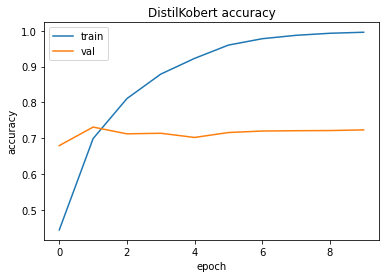

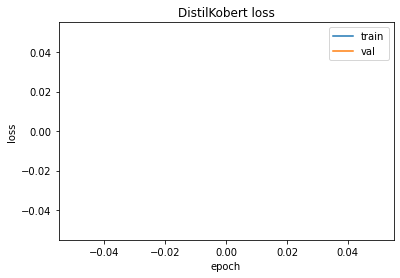

In [21]:
import matplotlib.pyplot as plt
plt.plot(train_acc_list)
plt.plot(valid_acc_list)
plt.title('Kobert accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train','val'])
plt.show()

plt.plot(train_loss_list)
plt.plot(valid_loss_list)
plt.title('Kobert loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()
     

In [22]:
#토큰화
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

def predict(sentence, answer):

    data = [sentence, '0']
    dataset_another = [data]

    another_test = BERTDataset(dataset_another, 0, 1, tok, max_len, True, False)
    test_dataloader = torch.utils.data.DataLoader(another_test, batch_size=batch_size, num_workers=5)
    
    model.eval()

    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)

        valid_length= valid_length
        label = label.long().to(device)

        out = model(token_ids, valid_length, segment_ids)

        test_eval=[]
        for i in out:
            logits = i
            logits = logits.detach().cpu().numpy()

            if np.argmax(logits) == 0:
                test_eval.append("행복")
            elif np.argmax(logits) == 1:
                test_eval.append("중립")
            elif np.argmax(logits) == 2:
                test_eval.append("불안")
            elif np.argmax(logits) == 3:
                test_eval.append("슬픔")
            elif np.argmax(logits) == 4:
                test_eval.append("분노")
        
        if answer == '0':
            answer = "행복"
        elif answer == '1':
            answer = "중립"
        elif answer == '2':
            answer = "불안"
        elif answer == '3':
            answer = "슬픔"
        elif answer == '4':
            answer = "분노"

        if test_eval[0] != answer:
          print("입력:", sentence, "/ 예측:" , test_eval[0], "/ 실제:", answer)

using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [ ]:
for i in range(test_size):
  predict(dataset_test[i][0], dataset_test[i][1])

입력:  잘못봤나?0 / 예측: 중립 / 실제: 불안
입력: 치약을 바꿨다거나 하지도 않았어요. / 예측: 불안 / 실제: 중립
입력:  찔끔거리다 요실금 올라 / 예측: 중립 / 실제: 불안
입력:  펜들에게 웃음을 주시는 것도 중요하지만오빠에 건강도 중요 하니깐 식사 꼭 챙겨드시고아프지 마세요 / 예측: 중립 / 실제: 불안
입력: 유산소 지겨워서 하기싫은데 어떡하죠?ㅠㅠ / 예측: 슬픔 / 실제: 중립
입력: 지금 대학등록을 앞두고 재수를 결심하고 있는데요 / 예측: 슬픔 / 실제: 중립
입력: 아니 하면다들재밌게볼꺼면서ㅋㅋㅋㅋㅋ / 예측: 행복 / 실제: 중립
입력: 물론 시즌말에 가서 떨어질꺼라 예상은 했다만,스크는 나름대로 잘 나가다가 왜 성적이 곤두박질 칠겨? / 예측: 중립 / 실제: 분노
입력: 이 시대 최고의 희소식 ㅋㅋㅋ / 예측: 중립 / 실제: 행복
입력: 저는 일자리 방출이 될지도 모르겠네요 / 예측: 불안 / 실제: 슬픔
입력: 딱 1주일뒤에 군대에 들어가게되는데.. / 예측: 슬픔 / 실제: 불안
입력:  이 동네 떠나야하는거 아니냐능0 / 예측: 불안 / 실제: 슬픔
입력: ㅋㅋㅋㅋㅋ짝수다 짝수!! / 예측: 행복 / 실제: 중립
입력: 중국한테도 지면 진짜 개망신이야... / 예측: 분노 / 실제: 불안
입력: 개편하고 그러는거보니 슬슬 프르그램의 마지막이 다가오는듯 / 예측: 행복 / 실제: 중립
입력:  언제까지 그런식으로 할건지요. / 예측: 불안 / 실제: 분노
입력: 운동도 해보고 공부도 해보고 게임도 해보고생각안나보려고 별짓을 다해봐도 몸은 솔직한지 자꾸 꼴리거든요; / 예측: 슬픔 / 실제: 불안
입력: 머지.....정말 그랫단말인가 / 예측: 슬픔 / 실제: 중립
입력: 강력하게 대응해라!!! / 예측: 불안 / 실제: 분노
입력: 저 한달쯤부터 손톱으로 손목을 긁어요... / 예측: 중립 / 실제: 불안
입력: 홍홍홍홍  웰케 잘생겨졌냐면서.. / 예측: 중립 / 실제: 행복
입력: 아.. 뭘 해야할지도 모르겠고